In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

START_YEAR = 1992
END_YEAR = 2020
HEM = 'sh'

PATH_SOURCE = "/home/jbassham/jack/data/sh"
PATH_DEST = "/home/jbassham/jack/data/sh/inputs"

In [2]:
# Extract variables

fnam = f"motion_ppv4_latlon_{HEM}_{START_YEAR}_{END_YEAR}.npz"
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
ui = data['u'] # zonal ice velocity
vi = data['v']
r = data['error'] # ice velocity uncertainty (for u and v)
lat = data['lat']
lon = data['lon']
time = data['time']

print('Velocity, Uncertainty Loaded')

fnam = f"con_nimbus7_latlon_{HEM}_{START_YEAR}_{END_YEAR}.npz"
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
ic = data['ic'] # ice concentration

print('Concentration Loaded')

print('Variable Files Loaded')

# Mask ice concentration
ic_raw = np.round(ic * 250) # raw value ice concentration (NSIDC)

# NSIDC Masks 
# 251 pole hole
# 252 unused data
# 253 coastline
# 254 land
ic = np.where((ic_raw == 251) | (ic_raw == 252) | (ic_raw == 253) | (ic_raw == 254), np.nan, ic)

print('ic masked')

# Shift present day parameters forward one day, for one point Middle Weddell
uit = ui[1:,:,:]
vit = vi[1:,:,:]

ict = ic[1:,:,:]
tt = time[1:]
rt = r[1:,:,:]

# Remove last day from previous day parameters
icy = ic[:-1,:,:]
ty = time[:-1]

print('days shifted')

Velocity, Uncertainty Loaded
Concentration Loaded
Variable Files Loaded
ic masked
days shifted


In [3]:
cit = np.sqrt(uit ** 2 + vit ** 2)

cit_std = np.nanstd(cit)

print(f"Std Ice Speed: {cit_std:.3f} cm/s")

Std Ice Speed: 7.939 cm/s


In [4]:
# Create list of input variables
invars = [uit, vit, rt, icy]
nvars = len(invars)
var_names = ['uit', 'vit', 'rt', 'icy']

# Calcluate pre-mask means and stds
globMeans = [np.nanmean(var) for var in invars]
gridMeans = [np.nanmean(var, axis = 0) for var in invars]

globStds = [np.nanstd(var) for var in invars]
gridStds = [np.nanstd(var, axis = 0) for var in invars]

for globMean, var_name in zip(globMeans, var_names):
    print(f"Mean {var_name}: {globMean:.3f}")    

print()

for globStd, var_name in zip(globStds, var_names):
    print(f"Std {var_name}: {globStd:.3f}")

/tmp/ipykernel_1727623/2489473480.py:8: RuntimeWarning: Mean of empty slice
  gridMeans = [np.nanmean(var, axis = 0) for var in invars]
/home/jbassham/miniconda3/envs/seaice/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Mean uit: -0.004
Mean vit: 2.188
Mean rt: 62.667
Mean icy: 0.515

Std uit: 9.492
Std vit: 8.360
Std rt: 60.647
Std icy: 0.403


In [5]:
# Mask spatial indices with concentration less than .15, NaN concentration
# NOTE keeping flag values for ice velocity uncertainties
mask2 = (ict <= .15) | (np.isnan(ict))

# NaN out points meeting mask condition
invarsMask2 = [np.where(mask2, np.nan, var) for var in invars]

# Calcluate first-masked means and stds
globMeans2 = [np.nanmean(var) for var in invarsMask2]
gridMeans2 = [np.nanmean(var, axis = 0) for var in invarsMask2]

globStds2 = [np.nanstd(var) for var in invarsMask2]
gridStds2 = [np.nanstd(var, axis = 0) for var in invarsMask2]

for globMean, var_name in zip(globMeans2, var_names):
    print(f"Mean {var_name}: {globMean:.3f}")    

print()

for globStd, var_name in zip(globStds2, var_names):
    print(f"Std {var_name}: {globStd:.3f}")

/tmp/ipykernel_1727623/4038096303.py:10: RuntimeWarning: Mean of empty slice
  gridMeans2 = [np.nanmean(var, axis = 0) for var in invarsMask2]


Mean uit: -0.005
Mean vit: 2.198
Mean rt: 62.547
Mean icy: 0.785

Std uit: 9.508
Std vit: 8.375
Std rt: 59.266
Std icy: 0.197


In [6]:
# Unpack masked variables
uit, vit, rt, icy = invarsMask2

In [7]:
print("Mean rt: {:.3f}".format(np.nanmean(rt)))
print("Std rt: {:.3f}".format(np.nanstd(rt)))
print('')
print("Min rt: {:.3f}".format(np.nanmin(rt)))
print("Max rt: {:.3f}".format(np.nanmax(rt)))

Mean rt: 62.547
Std rt: 59.266

Min rt: 4.000
Max rt: 1182.000


In [8]:
cit = np.sqrt(uit ** 2 + vit ** 2)

cit_std = np.nanstd(cit)

print(f"Std Ice Speed: {cit_std:.3f} cm/s")

# Normalize ice velocity uncertainty by std of ice speed
n_rt = rt / cit_std

Std Ice Speed: 7.937 cm/s


In [9]:
print("Mean n_rt: {:.3f}".format(np.nanmean(n_rt)))
print("Std n_rt: {:.3f}".format(np.nanstd(n_rt)))
print('')
print("Min n_rt: {:.3f}".format(np.nanmin(n_rt)))
print("Max n_rt: {:.3f}".format(np.nanmax(n_rt)))

Mean n_rt: 7.881
Std n_rt: 7.467

Min n_rt: 0.504
Max n_rt: 148.930


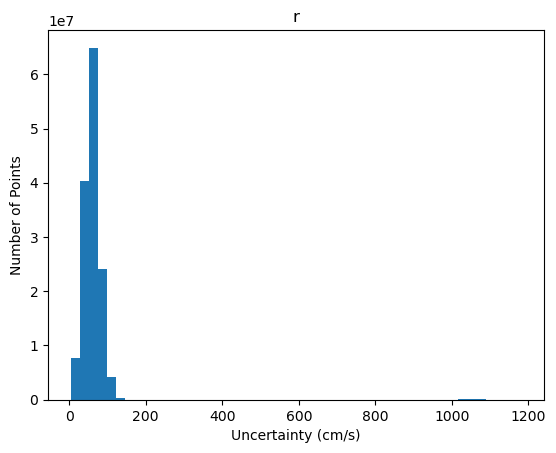

In [21]:
plt.hist(rt.flatten(), bins=50)
plt.xlabel('Uncertainty (cm/s)')
plt.ylabel('Number of Points')
plt.title('r')
plt.show()

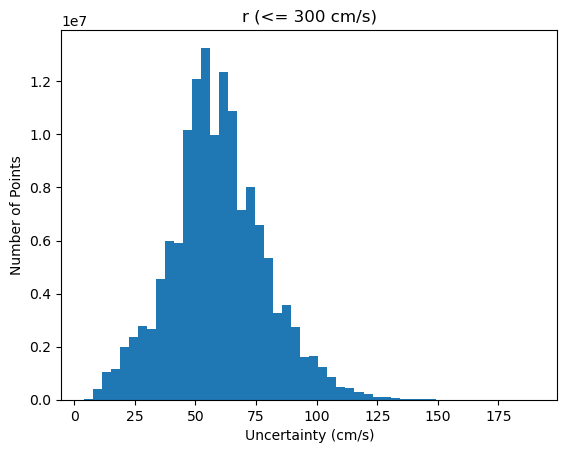

In [16]:
# Plot histogram values between 0 and 300
rt_masked = rt[(rt >= 0) & (rt <= 300)]

plt.hist(rt_masked.flatten(), bins=50)
plt.xlabel('Uncertainty (cm/s)')
plt.ylabel('Number of Points')
plt.title('r (<= 300 cm/s)')
plt.show()

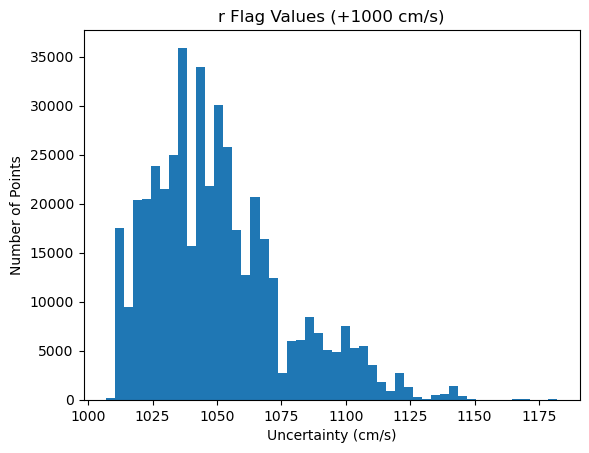

In [17]:
# Plot histogram values between 0 and 300
rt_masked = rt[(rt > 300) & (rt <= 1200)]

plt.hist(rt_masked.flatten(), bins=50)
plt.xlabel('Uncertainty (cm/s)')
plt.ylabel('Number of Points')
plt.title('r Flag Values (+1000 cm/s)')
plt.show()

In [18]:
log_n_rt = np.log(n_rt)

print("Mean log(n_rt): {:.3f}".format(np.nanmean(log_n_rt)))
print("Std log(n_rt): {:.3f}".format(np.nanstd(log_n_rt)))
print('')
print("Min log(n_rt): {:.3f}".format(np.nanmin(log_n_rt)))
print("Max log(n_rt): {:.3f}".format(np.nanmax(log_n_rt)))

Mean log(n_rt): 1.958
Std log(n_rt): 0.416

Min log(n_rt): -0.685
Max log(n_rt): 5.003


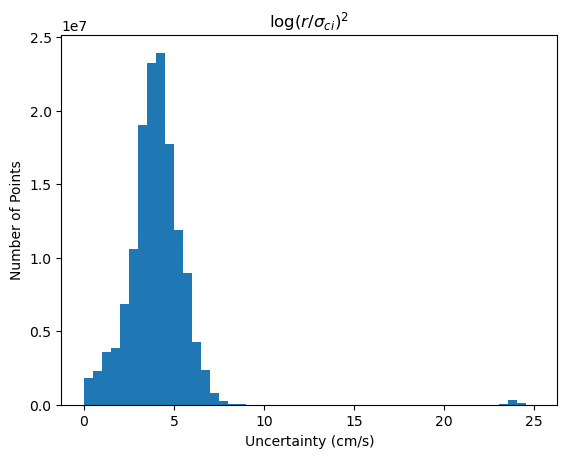

In [24]:
plt.hist(log_n_rt.flatten() ** 2, bins = 50)
plt.xlabel('Uncertainty (cm/s)')
plt.ylabel('Number of Points')
plt.title(r'$ \log(r/ \sigma_{ci})^2 $')
plt.show()